# Test Interstellar

This notebook is for various tests of the Interstellar code.

In [25]:
import interstellar as stel
import numpy as np
import pandas as pd
import pymc3 as pm
import theano
import keras

In [2]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [3]:
grid = stel.DenseNetworkGrid(path='output/test_interstellar', name='dng',
                             depth=[2, 3, 4], width=8, activation='elu',
                             batch_size=16, regularization_l2=0.0001)

In [4]:
grid.data

,depth,width,activation,batch_size,regularization_l2
name,,,,,
dng_0,2,8,elu,16,0.0001
dng_1,3,8,elu,16,0.0001
dng_2,4,8,elu,16,0.0001


In [5]:
grid.save_data()

In [6]:
grid.make_networks()

In [7]:
grid.build_all(1, 1)

In [8]:
grid.compile_all(loss='mae', metrics=['mse'])

In [9]:
grid.save_networks()

In [10]:
grid.save_data()

Make training data.

In [11]:
def f(x):
    return x**3 + 0.5

In [12]:
x = np.random.rand(500)
y = f(x)

train = pd.DataFrame({'input': x, 'output': y})
train.head()

,input,output
0,0.719041,0.871758
1,0.152374,0.503538
2,0.141279,0.502820
3,0.104266,0.501134
4,0.827224,1.066068


In [13]:
grid.train_all(train, x_cols=['input'], y_cols=['output'], epochs=100)

Make test data.

In [14]:
xx = np.linspace(0, 1, 50)
yy = f(xx)

test = pd.DataFrame({'input': xx, 'output': yy})
test.head()

,input,output
0,0.000000,0.500000
1,0.020408,0.500008
2,0.040816,0.500068
3,0.061224,0.500229
4,0.081633,0.500544


In [15]:
grid.evaluate_all(test)

,loss,mse
name,,
dng_0,0.088716,0.015652
dng_1,0.088785,0.016230
dng_2,0.070297,0.005225


In [16]:
grid.evaluate_all(test, inplace=True, save_data=True)

Score the networks, gives more detailed stats.

In [17]:
scores = grid.score_all(test)

In [18]:
scores.head()

output
dng_0 count  50.000000
      mean    0.087695
      std     0.090132
      min     0.002371
      25%     0.034493

Plot an example network

In [19]:
test['output_pred'] = grid.networks[2].predict(xx)

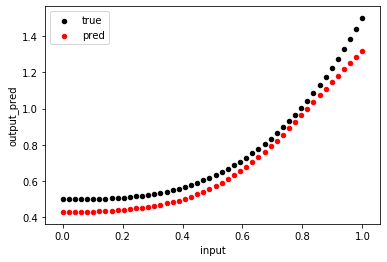

In [20]:
ax = test.plot(kind='scatter', x='input', y='output', c='k', label='true')
test.plot(ax=ax, kind='scatter', x='input', y='output_pred', c='r', label='pred')
ax.legend()

How to load an individual network from a config file.

In [153]:
net = stel.DenseNetwork.from_config('output/test_interstellar/dng_1/dng_1_config.json')
net.load_model()
net.model.summary()

Model: "dng_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 1)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 16        
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


How about we try making predictions in PyMC3. Can use network.to_theano(), but here we experiement with Lasagne and I reference https://gist.github.com/anonymous/96b998304de1eb4306738543170788ca which is a fun example of using PyMC3 to train a neural net. Here, we are just using its predictions.

In [154]:
import lasagne

In [155]:
weights = net.model.get_weights()

In [249]:
def predict(t):
    
    input_layer = lasagne.layers.InputLayer(shape=(None, 1), input_var=t)

    xx = lasagne.layers.DenseLayer(
        input_layer, num_units=8,
        nonlinearity=lasagne.nonlinearities.elu,
        W=weights[0],
        b=weights[1])

    for i in range(1, 3):
        xx = lasagne.layers.DenseLayer(
            xx, num_units=8,
            nonlinearity=lasagne.nonlinearities.elu,
            W=weights[2*i],
            b=weights[2*i + 1])

    output_layer = lasagne.layers.DenseLayer(
            xx, num_units=1,
            W=weights[-2],
            b=weights[-1])
    
    prediction = lasagne.layers.get_output(output_layer, deterministic=True)
    return prediction 

If we wanted to create above with a symbolic tensor, we can do it like this, to give us human readable output.

In [250]:
input_var = theano.tensor.matrix('input_var')
input_var.tag.test_value = np.zeros((10, 1)).astype('float32')

predict_func = theano.function([input_var], predict(input_var))
predict_func(np.array([0.1, 0.3, 0.5])[:, np.newaxis()])

In [251]:
with pm.Model() as model:
    xs = pm.Normal('xs', 0.5, 0.05, shape=(10, 1))
    ys = pm.Deterministic('ys', predict(xs))

In [252]:
with model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [xs]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2929.27draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x152872910>,
      dtype=object)

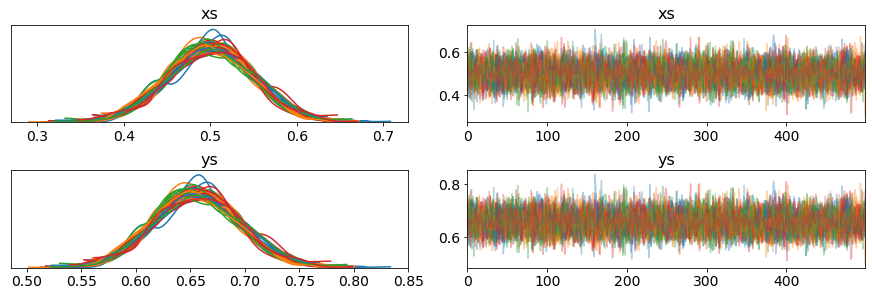

In [253]:
pm.traceplot(trace)

Compare with basic theano function.

In [254]:
predict2 = net.to_theano()

In [255]:
with pm.Model() as model:
    xs = pm.Normal('xs', 0.5, 0.05, shape=(10, 1))
    ys = pm.Deterministic('ys', predict2(xs))

In [256]:
with model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [xs]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2910.10draws/s]


In [225]:
%timeit predict(theano.shared(np.array([0.5])[:, np.newaxis]))

27 ms ± 173 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [226]:
%timeit predict2(theano.shared(np.array([0.5])[:, np.newaxis]))

31.3 ms ± 149 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
